In [ ]:
!gcloud auth login

In [1]:
import os

import hail as hl
import numpy as np
import pyspark.sql.functions as f
from pyspark.sql import DataFrame

from gentropy.common.session import Session
from gentropy.dataset.study_index import StudyIndex
from gentropy.dataset.summary_statistics import SummaryStatistics
from gentropy.dataset.study_locus import StudyLocus
from gentropy.susie_finemapper import SusieFineMapperStep
from gentropy.method.drug_enrichment_from_evid import chemblDrugEnrichment

"""Common utilities for the project."""

import os
from pathlib import Path
from gentropy.common.session import Session
import logging


def get_gcs_credentials() -> str:
    """Get the credentials for google cloud storage."""
    app_default_credentials = os.path.join(
        os.getenv("HOME", "."), ".config/gcloud/application_default_credentials.json"
    )

    service_account_credentials = os.path.join(
        os.getenv("HOME", "."), ".config/gcloud/service_account_credentials.json"
    )

    if Path(app_default_credentials).exists():
        return app_default_credentials
    else:
        raise FileNotFoundError("No GCS credentials found.")


def get_gcs_hadoop_connector_jar() -> str:
    """Get the google cloud storage hadoop connector for spark.

    This function will return the url to download the hadoop jar.
    """

    return (
        "https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar"
    )


def gcs_conf(
    credentials_path=None, project="open-targets-genetics-dev"
) -> dict[str, str]:
    """Get the spark configuration with hadoop connector for google cloud storage."""
    credentials_path = credentials_path or get_gcs_credentials()
    return {
        "spark.driver.memory": "12g",
        "spark.kryoserializer.buffer.max": "500m",
        "spark.driver.maxResultSize":"2g",
        "spark.hadoop.fs.gs.impl": "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem",
        "spark.jars": get_gcs_hadoop_connector_jar(),
        "spark.hadoop.google.cloud.auth.service.account.enable": "true",
        "spark.hadoop.fs.gs.project.id": project,
        "spark.hadoop.google.cloud.auth.service.account.json.keyfile": credentials_path,
        "spark.hadoop.fs.gs.requester.pays.mode": "AUTO",
    }


class GentropySession(Session):
    def __init__(self, *args, **kwargs):
        if "extended_spark_conf" in kwargs:
            kwargs["extended_spark_conf"].update(gcs_conf())
        else:
            kwargs["extended_spark_conf"] = gcs_conf()
        super().__init__(*args, **kwargs)

    @property
    def conf(self):
        logging.warning(
            "To change the config restart the session and use the `extended_spark_conf` parameter."
        )
        return self.spark.sparkContext.getConf().getAll()

session= GentropySession()


Loading BokehJS ...

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/02 18:06:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
path_to_release_folder="gs://open-targets-data-releases/25.06/"


si=StudyIndex.from_parquet(session,path_to_release_folder+"output/study/")
sl=StudyLocus.from_parquet(session,path_to_release_folder+"output/credible_set/")

In [3]:
# combinig it with l2g predictions
l2g=session.spark.read.parquet("gs://ot-team/irene/l2g/xgboost/2706/l2g_predictions").select("studyLocusId","geneId","score")

In [4]:
fm=session.spark.read.parquet(path_to_release_folder+"intermediate/l2g_feature_matrix/")
fm=fm.filter(f.col("isProteinCoding")==1).cache()
fm.count()

25/06/27 14:30:09 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


10623371

In [26]:
combined_df = fm.join(l2g.select("studyLocusId", "geneId", "score"), on=["geneId", "studyLocusId"], how="left").fillna(0).cache()
combined_df.count()

25/06/27 14:49:20 WARN CacheManager: Asked to cache already cached data.


10623371

In [27]:
clpp_thr=0.01
coloc_thr=0.8

combined_df = combined_df.withColumn(
    "eQTL_coloc",
    f.when(
    (f.col("eQtlColocClppMaximum")>=clpp_thr) | 
    (f.col("eQtlColocH4Maximum")>=coloc_thr), 1).otherwise(0)
)
combined_df = combined_df.withColumn(
    "pQTL_coloc",
    f.when(
    (f.col("pQtlColocClppMaximum")>=clpp_thr) | 
    (f.col("pQtlColocH4Maximum")>=coloc_thr), 1).otherwise(0)
)
combined_df = combined_df.withColumn(
    "VEP",
    f.when((f.col("vepMaximum")>=0.66), 1).otherwise(0)
)
#combined_df = combined_df.withColumn(
#    "distance",
#    f.when((f.col("distanceSentinelFootprintNeighbourhood")==1) |
#    (f.col("distanceSentinelTssNeighbourhood")==1), 1).otherwise(0)
#).cache()

combined_df = combined_df.withColumn(
    "distanceTSS",
    f.when(f.col("distanceSentinelTssNeighbourhood")==1, 1).otherwise(0)
).cache()



combined_df.count()

10623371

In [7]:
l2g_05=l2g.filter(f.col("score")>=0.5).cache()
cs_with_l2g=l2g_05.select("studyLocusId").distinct()
cs_with_l2g.count()

499878

In [16]:
l2g_05.count()

524241

In [8]:
l2g_no_05=l2g.join(cs_with_l2g, on="studyLocusId", how="left_anti").cache()
l2g_no_05.count()

4679891

In [9]:
l2g_no_05.select("studyLocusId").distinct().count()

274431

In [10]:
from pyspark.sql import Window

# Define a window specification partitioned by studyLocusId and ordered by score descending
window_spec = Window.partitionBy("studyLocusId").orderBy(f.desc("score"))

# Add a row_number column to rank rows within each studyLocusId partition
l2g_no_05_ranked = l2g_no_05.withColumn("row_number", f.row_number().over(window_spec))

# Filter rows where row_number is 1 (i.e., the max score for each studyLocusId)
l2g_no_05_max = l2g_no_05_ranked.filter(f.col("row_number") == 1).drop("row_number")

# Show the result
l2g_no_05_max.count()

274431

In [11]:
l2g_no_05_max.select("studyLocusId").distinct().count()

274431

In [13]:
l2g_no_05_max.show(4)

+--------------------+---------------+----------+
|        studyLocusId|         geneId|     score|
+--------------------+---------------+----------+
|002462a2da2f7c279...|ENSG00000215547|0.47645262|
|00a70f45252881a9f...|ENSG00000254636| 0.4249295|
|00badf4cd2ff71a2c...|ENSG00000105655|0.20505728|
|00bbe340d79fe1aa1...|ENSG00000077549|0.44006506|
+--------------------+---------------+----------+
only showing top 4 rows



In [18]:
l2g_no_05_max_01=l2g_no_05_max.filter(f.col("score")>=0.1).cache()
l2g_no_05_max_01.count()

261020

In [19]:
l2g_prioritised=l2g_no_05_max_01.unionByName(l2g_05.select("studyLocusId", "geneId", "score")).cache()
l2g_prioritised.count()

785261

In [20]:
261020+524241

785261

In [22]:
l2g_prioritised.show(1)

+--------------------+---------------+----------+
|        studyLocusId|         geneId|     score|
+--------------------+---------------+----------+
|002462a2da2f7c279...|ENSG00000215547|0.47645262|
+--------------------+---------------+----------+
only showing top 1 row



In [31]:
final=combined_df.select(
    "studyLocusId",
    "geneId",
    "score",
    "eQTL_coloc",
    "pQTL_coloc",
    "VEP",
    "distanceTSS"
).join(
    l2g_prioritised.drop("score"),
    on=["studyLocusId", "geneId"],
    how="inner"
).cache()
final.count()

785261

In [32]:
final.show(2)

+--------------------+---------------+----------+----------+----------+---+-----------+
|        studyLocusId|         geneId|     score|eQTL_coloc|pQTL_coloc|VEP|distanceTSS|
+--------------------+---------------+----------+----------+----------+---+-----------+
|2ef4eb65d7f430a75...|ENSG00000000971| 0.7004741|         0|         0|  0|          1|
|469a4c2b6f1247cbe...|ENSG00000000971|0.76636124|         1|         0|  1|          1|
+--------------------+---------------+----------+----------+----------+---+-----------+
only showing top 2 rows



In [34]:
final.select("studyLocusId").distinct().count()

760898

In [33]:
final.write.mode("overwrite").parquet("gs://genetics-portal-dev-analysis/yt4/20250403_for_gentropy_paper/list_of_prioritised_genes_per_CS.parquet")

In [3]:
final=session.spark.read.parquet("gs://genetics-portal-dev-analysis/yt4/20250403_for_gentropy_paper/list_of_prioritised_genes_per_CS.parquet")

In [6]:
final_pd=final.toPandas()

<Figure size 800x800 with 0 Axes>

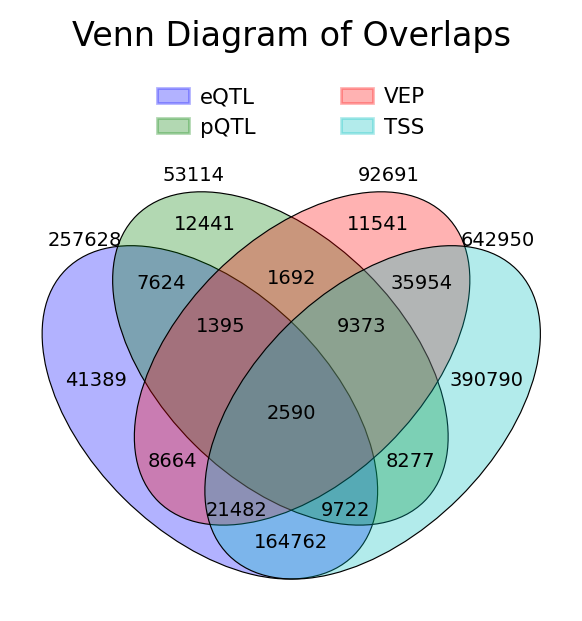

In [9]:
eQTL = set(final_pd.index[final_pd["eQTL_coloc"] == 1])
pQTL = set(final_pd.index[final_pd["pQTL_coloc"] == 1])
VEP = set(final_pd.index[final_pd["VEP"] == 1])
TSS = set(final_pd.index[final_pd["distanceTSS"] == 1])




from venny4py.venny4py import *

#dict of sets
sets = {
    'eQTL': eQTL,
    'pQTL': pQTL,
    'VEP': VEP,
    'TSS': TSS
}



# For 4 sets, use venn4 from matplotlib-venn (install with pip if needed)
plt.figure(figsize=(8,8))
venny4py(sets=sets)
plt.title("Venn Diagram of Overlaps")
plt.show()

In [4]:
to_exclude=si.df.filter(f.col("pubmedId").isin([40164604,40229599,40069456])).select("studyId")
to_exclude.count()

80

In [5]:
studyLocusId_to_exclude=sl.df.join(to_exclude,on="studyId",how="inner").select("studyLocusId").distinct().cache()
studyLocusId_to_exclude.count()

10735

In [6]:
studyLocusId_to_exclude.write.parquet("gs://genetics-portal-dev-analysis/yt4/20250403_for_gentropy_paper/studyLocusId_to_exclude.parquet")